In [7]:
import polars as pl

predicted_path = '../data/v9/agg_results.csv'
measured_path = '../data/crack measurements 4680.xlsx'

In [8]:
df = pl.read_csv(predicted_path)
df_measured = pl.read_excel(measured_path)

In [9]:
df

image_name,seg_confidence,crack_length_mm
str,f64,f64
"""stitched_10.jpg""",0.910278,4.254262
"""stitched_100.jpg""",0.905613,2.844721
"""stitched_101.jpg""",0.748462,3.293621
"""stitched_102.jpg""",0.914799,2.465996
"""stitched_103.jpg""",0.939162,3.004749
…,…,…
"""stitched_95.jpg""",0.88098,2.374826
"""stitched_96.jpg""",0.789659,1.0763
"""stitched_97.jpg""",0.909516,3.192501


In [10]:
df = df.with_columns(
    pl.col('image_name').str.extract(r'(\d+)', 1).cast(pl.Int64).alias('image_id')
)

In [11]:
df_measured = df_measured.rename({'crack length (mm)' : 'measured_crack_length_mm'})
df = df.rename({'crack_length_mm': 'predicted_crack_length_mm'})
df = df.join(df_measured, left_on='image_id', right_on='sample', how='left')

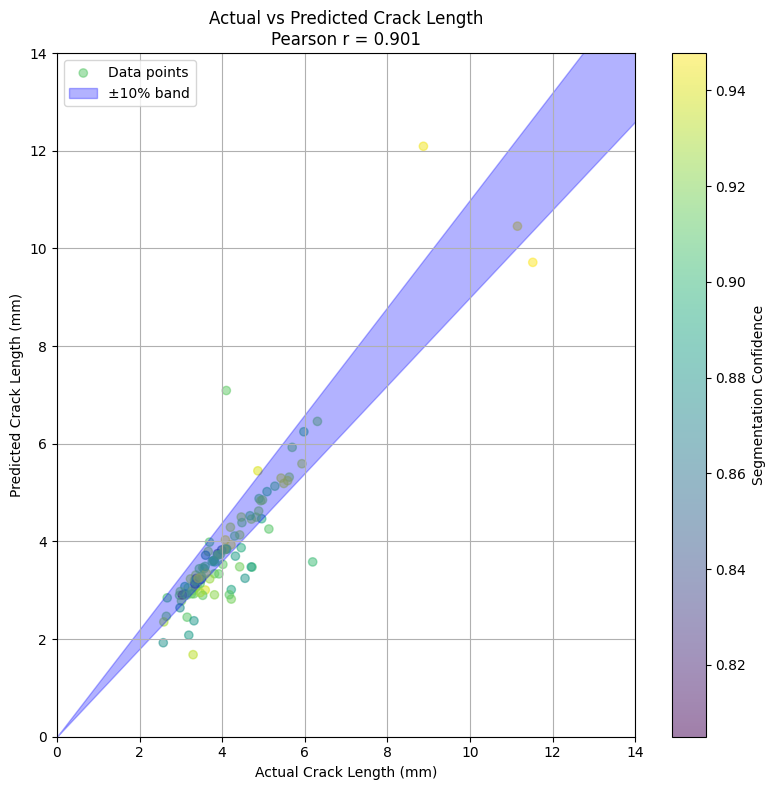

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

df = df.filter(
    (pl.col('predicted_crack_length_mm').is_not_nan())
    & (pl.col('seg_confidence') > 0.8)
)

x = df['measured_crack_length_mm'].to_numpy()
y = df['predicted_crack_length_mm'].to_numpy()
confidence = df['seg_confidence'].to_numpy()

equal_line = np.linspace(0, 14, 100)
lower = equal_line * 0.9
upper = equal_line * 1.1

corr, p_value = pearsonr(x, y)


plt.figure(figsize=(8, 8))
plt.scatter(x, y, c=confidence, alpha=0.5, label='Data points')
plt.fill_between(equal_line, lower, upper, color='blue', alpha=0.3, label='±10% band')

plt.xlim(0, 14)
plt.ylim(0, 14)

plt.xlabel('Actual Crack Length (mm)')
plt.ylabel('Predicted Crack Length (mm)')
plt.title(f'Actual vs Predicted Crack Length\nPearson r = {corr:.3f}')
plt.grid(True)
# plt.axis('equal')
plt.colorbar(label='Segmentation Confidence')
plt.legend()
plt.tight_layout()
plt.show()